1. Mounting Google Drive...
Mounted at /content/drive

2. Loading datasets...
X_train shape: (17411, 11), y_train shape: (17411,)
X_test shape: (5581, 11), y_test shape: (5581,)

3. Setting up GridSearchCV for Decision Tree...

4. Starting Grid Search (Hyperparameter Tuning)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Grid Search completed in 16.82 seconds.

--- Decision Tree Model Evaluation ---
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Set Accuracy: 0.7662

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.67      0.70      2343
           1       0.78      0.84      0.81      3238

    accuracy                           0.77      5581
   macro avg       0.76      0.75      0.76      5581
weighted avg       0.76      0.77      0.76      5581


6. Generating Visualizations...


/tmp/ipython-input-870300860.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')


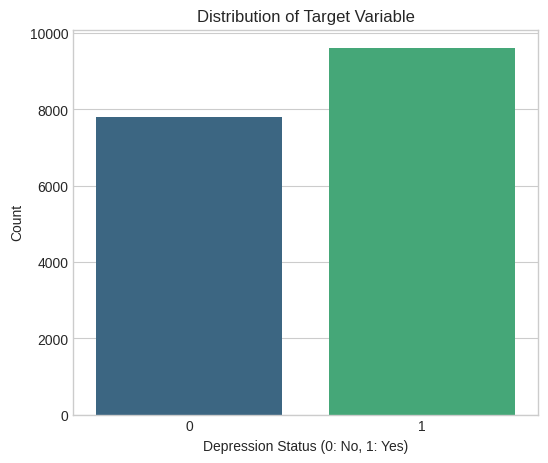

/tmp/ipython-input-870300860.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')


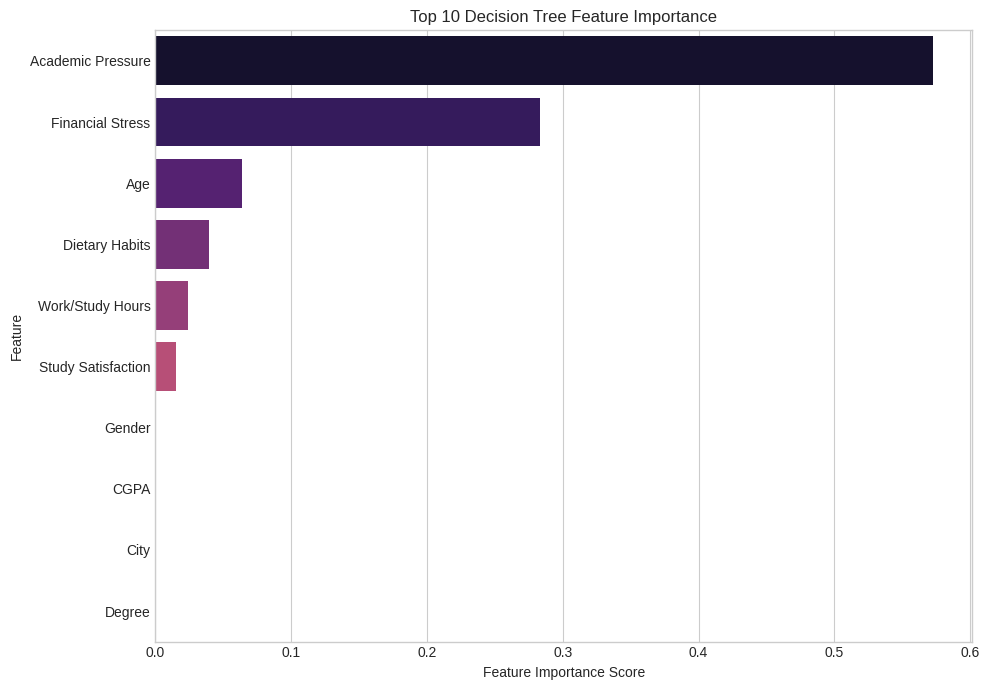

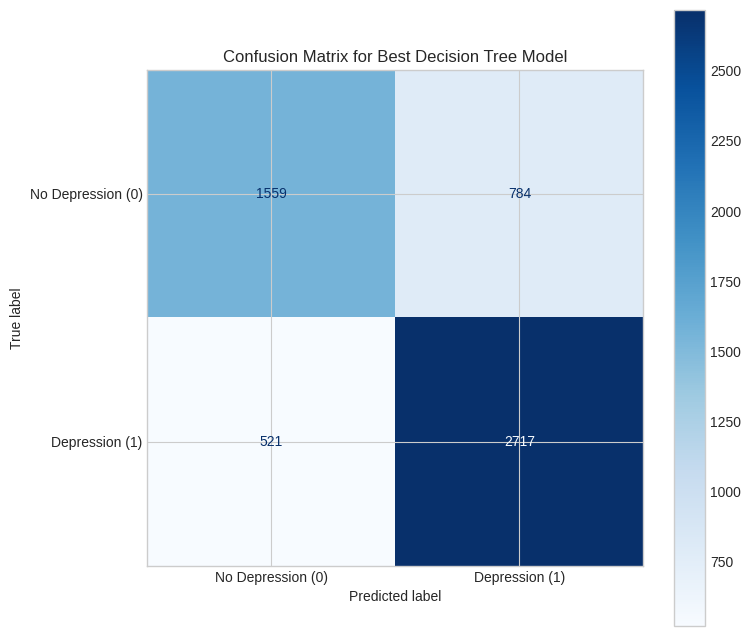


7. Visualizing the Decision Tree (Top 3 levels)...


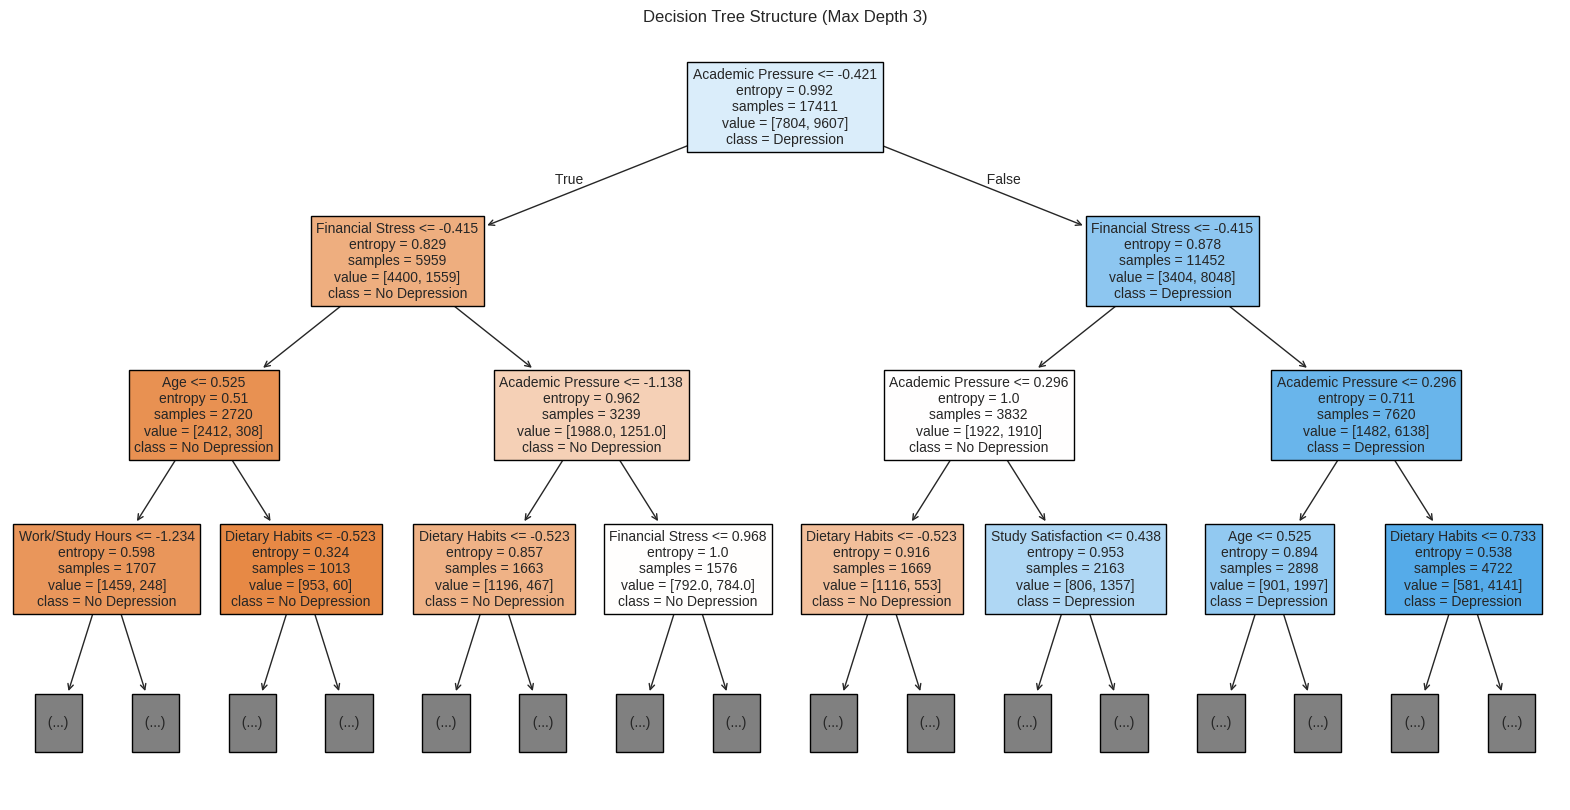

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time

# -----------------------------------------------------------------------------
# 1. MOUNT GOOGLE DRIVE
# -----------------------------------------------------------------------------
print("1. Mounting Google Drive...")
# This will prompt you to authorize Colab to access your Drive
drive.mount('/content/drive')

# -----------------------------------------------------------------------------
# 2. FILE PATH AND DATA LOADING (Fixes all loading errors)
# -----------------------------------------------------------------------------
# 🚨 ACTION REQUIRED: CHECK AND ADJUST THIS PATH 🚨
# If your files are in a folder (e.g., 'ML_Data') inside 'My Drive', use:
# path_prefix = '/content/drive/MyDrive/ML_Data/'
path_prefix = '/content/drive/MyDrive/' # Default: files are in the root of My Drive
TARGET_COLUMN = 'Depression'

print("\n2. Loading datasets...")
try:
    # 🔑 FIX for Feature Importance Error: Use index_col=0 to drop the unwanted index column
    X_train = pd.read_csv(path_prefix + 'X_train_final.csv', index_col=0)
    X_test = pd.read_csv(path_prefix + 'X_test_final.csv', index_col=0)

    # Load targets (y)
    y_train_df = pd.read_csv(path_prefix + 'y_train_final.csv')
    y_test_df = pd.read_csv(path_prefix + 'y_test_final.csv')

    # 🔑 FIX for "Ambiguous Series" Error: Convert y to a 1D NumPy array
    if TARGET_COLUMN in y_train_df.columns:
        y_train = y_train_df[TARGET_COLUMN].values.ravel()
        y_test = y_test_df[TARGET_COLUMN].values.ravel()
    else:
        # Fallback: Assume the target is the first column
        y_train = y_train_df.iloc[:, 0].values.ravel()
        y_test = y_test_df.iloc[:, 0].values.ravel()


    # Final shape check
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

except FileNotFoundError as e:
    print(f"\n--- FATAL ERROR: File not found. Check your 'path_prefix' and file names. ---")
    print(f"Attempted path: {path_prefix}")
    exit()

# -----------------------------------------------------------------------------
# 3. HYPERPARAMETER TUNING (Grid Search)
# -----------------------------------------------------------------------------
print("\n3. Setting up GridSearchCV for Decision Tree...")

dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for Grid Search
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5]
}

# Setup Grid Search with 5-fold Cross-Validation
grid_search = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid_dt,
    cv=5, # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

print("\n4. Starting Grid Search (Hyperparameter Tuning)...")
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
print(f"Grid Search completed in {end_time - start_time:.2f} seconds.")

# Get the best model and predictions
best_dt_model = grid_search.best_estimator_
y_pred = best_dt_model.predict(X_test)

# -----------------------------------------------------------------------------
# 5. MODEL EVALUATION
# -----------------------------------------------------------------------------
print("\n--- Decision Tree Model Evaluation ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# -----------------------------------------------------------------------------
# 6. DATA VISUALIZATION
# -----------------------------------------------------------------------------

print("\n6. Generating Visualizations...")
plt.style.use('seaborn-v0_8-whitegrid')

# --- 6.1. Target Variable Distribution ---
plt.figure(figsize=(6, 5))
sns.countplot(x=y_train, palette='viridis')
plt.title('Distribution of Target Variable')
plt.xlabel('Depression Status (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# --- 6.2. Feature Importance Plot ---
feature_importances = best_dt_model.feature_importances_
feature_names = X_train.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(10) # Show top 10 for clarity

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')
plt.title('Top 10 Decision Tree Feature Importance')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 6.3. Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred, labels=best_dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Depression (0)', 'Depression (1)'])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title('Confusion Matrix for Best Decision Tree Model')
plt.show()

# --- 6.4. (Optional) Visualize the Decision Tree Structure (Pruned) ---
print("\n7. Visualizing the Decision Tree (Top 3 levels)...")
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model,
    feature_names=X_train.columns.tolist(),
    class_names=['No Depression', 'Depression'],
    filled=True,
    max_depth=3, # Limit depth for readability
    fontsize=10
)
plt.title('Decision Tree Structure (Max Depth 3)')
plt.show()